# pyDeepDelta Demo Notebook
### Author: Geir K. Nilsen (geir.kjetil.nilsen@gmail.com), (c) 2018-2021

# 1. Define MNIST network

In [1]:
import tqdm
import numpy as np
from utils import *
import os
import random

import tensorflow.compat.v1 as tf
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.disable_v2_behavior()

# Import MNIST data & convert 2D images to scaled 1D vectors, and labels to one hot format
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
N_train = X_train.shape[0]
N_test = X_test.shape[0]
X_train = np.float32(np.reshape(X_train, (N_train, 784)) / 255.)
X_test = np.float32(np.reshape(X_test, (N_test, 784)) / 255.)
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)

# Close current graph session if any is already open
if('sess' in locals()):
    sess.close()
tf.reset_default_graph()

# Parameters
learning_rate = tf.placeholder(tf.float32)
dropout_rate = tf.placeholder(tf.float32)
reg_lambda_val = 0.01
num_steps = 90000
T1 = 784
TL = 10

# Set random seed for repeatability.
rseed=0
np.random.seed(rseed)
random.seed(rseed)
tf.random.set_random_seed(seed=rseed)

# Random weight init
weights = {
'wc1': tf.Variable(tf.random.normal((3, 3, 1, 32)), dtype='float32'),
'wc2': tf.Variable(tf.random.normal((3, 3, 32, 64)), dtype='float32'),
'wc3': tf.Variable(tf.random.normal((3, 3, 64, 64)), dtype='float32'),
'wd1': tf.Variable(tf.random.normal((3 * 3 * 64, 64)), dtype='float32'),
'out': tf.Variable(tf.random.normal((64, TL)), dtype='float32')
}

# Biases init to zero
biases = {
'bc1': tf.Variable(tf.zeros((32)), dtype='float32'),
'bc2': tf.Variable(tf.zeros((64)), dtype='float32'),
'bc3': tf.Variable(tf.zeros((64)), dtype='float32'),
'bd1': tf.Variable(tf.zeros((64)), dtype='float32'),
'out': tf.Variable(tf.zeros((TL)), dtype='float32')
}

# Stack parameters layer-wise, weights first then biases
params = [weights['wc1'], biases['bc1'], 
      weights['wc2'], biases['bc2'], 
      weights['wc3'], biases['bc3'], 
      weights['wd1'], biases['bd1'], 
      weights['out'], biases['out']]

# Model input/output
X = tf.placeholder(dtype='float32', shape=(None, T1), name="X-data")
y = tf.placeholder(dtype='float32', shape=(None, TL), name="y-data")

# L2-regularization parameter
reg_lambda = tf.placeholder(tf.float32)

# Cost function, data only
def cost_fun_data(y, yhat_logits):
    cost_data = tf.losses.softmax_cross_entropy(y, yhat_logits)
    return cost_data

# Cost function, reg. only
def cost_fun_reg(params):
    cost_reg = reg_lambda/2.0*tf.reduce_sum([tf.reduce_sum(tf.pow(params[x], 2.0)) \
                                             for x in range(len(params))])
    return cost_reg

# Cost function, data + reg.
def cost_fun(y, yhat_logits, params):
    return cost_fun_data(y, yhat_logits) + cost_fun_reg(params)

# Model function
def model_fun(x, params):
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    conv1 = conv2d(x, params[0], params[1])
    conv1 = maxpool2d(conv1, k=2)

    conv2 = conv2d(conv1, params[2], params[3])
    conv2 = maxpool2d(conv2, k=2)

    conv3 = conv2d(conv2, params[4], params[5])

    fc1 = tf.reshape(conv3, [-1, 3*3*64])
    fc1 = tf.add(tf.matmul(fc1, params[6]), params[7])
    fc1 = tf.nn.relu(fc1)

    out = tf.add(tf.matmul(fc1, params[8]), params[9])
    return out

# Construct model
yhat_logits = model_fun(X, params)
yhat = tf.nn.softmax(yhat_logits)

# Define cost and optimizer
cost = cost_fun(y, yhat_logits, params)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
train_op = optimizer.minimize(cost)

# For model evaluation
correct_pred = tf.equal(tf.argmax(yhat, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize variables and session
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()

# Run the initializer
sess.run(init)

Instructions for updating:
non-resource variables are not supported in the long term


# 2.1. Train network

In [2]:
step = 0
num_steps = 90000
_learning_rate=10e-4
batch_size = 100
display_step = 7500
B = int(N_train / batch_size)

# Training loop
while step < num_steps:
    batch_x = X_train[step%B*batch_size:(step%B+1)*batch_size]
    batch_y = y_train[step%B*batch_size:(step%B+1)*batch_size]

    sess.run(train_op, feed_dict={X: batch_x, y: batch_y, reg_lambda: reg_lambda_val, learning_rate:_learning_rate})
    if step % display_step == 0 or step == 1:
        # Calculate batch loss and accuracy
        train_cost, train_acc = sess.run([cost, accuracy],
                                               feed_dict={X: batch_x,
                                                          y: batch_y,
                                                          reg_lambda: reg_lambda_val})

        val_cost, val_acc = sess.run([cost, accuracy], feed_dict={X:X_test,
                                                                  y:y_test,
                                                                  reg_lambda: reg_lambda_val})
        print("Step " + str(step) + ", Train. Cost=" + "{:.4f}".format(train_cost) + \
                                    ", Train. Acc.= " + "{:.4f}".format(train_acc) + \
                                    ", Val. Cost=" + "{:.3f}".format(val_cost) + \
                                    ", Val. Acc.= " + "{: 4f}".format(val_acc))

    # lr-schedule
    if step == 60000:
        _learning_rate = 10e-5
    if step == 70000:
        _learning_rate = 10e-6
    if step == 80000:
        _learning_rate = 10e-7

    step = step + 1 

print("Optimization finished.")

# save model
saver = tf.train.Saver()
saver.save(sess, 'data/model_rseed_%d_num_steps_%d_reg_lambda_%.2f.ckpt' % (rseed, num_steps, reg_lambda_val))

Step 0, Train. Cost=46735.4883, Train. Acc.= 0.1100, Val. Cost=42959.969, Val. Acc.=  0.120500
Step 1, Train. Cost=38702.9414, Train. Acc.= 0.1300, Val. Cost=39109.223, Val. Acc.=  0.119600
Step 7500, Train. Cost=374.9821, Train. Acc.= 0.9900, Val. Cost=438.699, Val. Acc.=  0.964200
Step 15000, Train. Cost=227.8951, Train. Acc.= 1.0000, Val. Cost=271.631, Val. Acc.=  0.975700
Step 22500, Train. Cost=138.1731, Train. Acc.= 1.0000, Val. Cost=159.666, Val. Acc.=  0.980100
Step 30000, Train. Cost=70.8848, Train. Acc.= 1.0000, Val. Cost=83.262, Val. Acc.=  0.975000
Step 37500, Train. Cost=24.8160, Train. Acc.= 0.9900, Val. Cost=26.291, Val. Acc.=  0.980800
Step 45000, Train. Cost=1.4010, Train. Acc.= 0.9800, Val. Cost=1.377, Val. Acc.=  0.981900
Step 52500, Train. Cost=0.3070, Train. Acc.= 0.9700, Val. Cost=0.284, Val. Acc.=  0.976700
Step 60000, Train. Cost=0.2660, Train. Acc.= 0.9800, Val. Cost=0.272, Val. Acc.=  0.974900
Step 67500, Train. Cost=0.2814, Train. Acc.= 0.9700, Val. Cost=0.25

'data/model_rseed_0_num_steps_90000_reg_lambda_0.01.ckpt'

# 2.2. ...or load pre-trained network

In [2]:
saver = tf.train.Saver()
saver.restore(sess, 'data/model_rseed_%d_num_steps_%d_reg_lambda_%.2f.ckpt' % (rseed, num_steps, reg_lambda_val))

INFO:tensorflow:Restoring parameters from data/model_rseed_0_num_steps_90000_reg_lambda_0.01.ckpt


# 3. Display training statistics

In [23]:
batch_size = 100
B = int(N_train/batch_size)
preds_train = np.concatenate([sess.run(yhat, 
                                       feed_dict={X: X_train[b*batch_size:(b+1)*batch_size]}) 
                              for b in tqdm.tqdm(range(B), position=0, leave=True)])
acc_train = np.mean([sess.run(accuracy, 
                              feed_dict={X: X_train[b*batch_size:(b+1)*batch_size], 
                                         y: y_train[b*batch_size:(b+1)*batch_size]}) 
                     for b in tqdm.tqdm(range(B), position=0, leave=True)])

B = int(N_test/batch_size)
preds_test = np.concatenate([sess.run(yhat, 
                                      feed_dict = {X: X_test[b*batch_size:(b+1)*batch_size]}) 
                             for b in tqdm.tqdm(range(B), position=0, leave=True)])
acc_test = np.mean([sess.run(accuracy, 
                             feed_dict={X: X_test[b*batch_size:(b+1)*batch_size], 
                                        y: y_test[b*batch_size:(b+1)*batch_size]}) 
                    for b in tqdm.tqdm(range(B), position=0, leave=True)])

batch_size = 100
B = int(N_train/batch_size)
cost_val = 0
for b in tqdm.tqdm(range(B), position=0, leave=True):
    cost_val = cost_val + sess.run(cost, feed_dict={X:X_train[b*batch_size:(b+1)*batch_size], 
                                                    y:y_train[b*batch_size:(b+1)*batch_size], 
                                                    reg_lambda:reg_lambda_val})
cost_val = np.squeeze(cost_val / B)

cost_train = cost_val

dCdw_op = tf.concat([tf.reshape(tf.gradients(cost, _params), [-1]) \
                     for _params in params], axis=0)
dCdw = 0

for b in tqdm.tqdm(range(B), position=0, leave=True):
    dCdw = dCdw + sess.run(dCdw_op, feed_dict={X:X_train[b*batch_size:(b+1)*batch_size], 
                                               y:y_train[b*batch_size:(b+1)*batch_size], 
                                               reg_lambda:reg_lambda_val})
normgrad_train = np.linalg.norm(np.squeeze(dCdw / B))

print('Tot. training cost: %.3f' % cost_train)
print('Norm of gradient: %.3f' % normgrad_train)

print('Training set accuracy: %.3f%%' % (100*acc_train))
print('Test set accuracy: %.3f%%' % (100*acc_test))


100%|██████████| 600/600 [00:03<00:00, 177.47it/s]

Tot. training cost: 0.258
Norm of gradient: 0.016
Training set accuracy: 97.970%
Test set accuracy: 98.110%


# 4. Initialize pydeepdelta

In [3]:
import pydeepdelta as pydd

dd = pydd.DeepDelta(params, cost, reg_lambda, reg_lambda_val, yhat, X, y,   
                    X_train, y_train, batch_size_H=7500, K=600, tfsession=sess, 
                    layers=['2wb', '3wb', '4wb', '5wb', '6wb'], rseed=rseed,
                    batch_size_G=200, model_fun=model_fun, cost_fun=cost_fun, 
                    cost_fun_data=cost_fun_data, dropout_rate=dropout_rate, 
                    dropout_rate_val=0.0, batch_size_F=100)

DeepDelta initialized.
P = 93322, K = 600, N = 60000


# 4.1 OPG estimator

## 4.1.1 Compute, store & initialize eigendecomposition

In [4]:
Lambda_G, Q_G = dd.compute_eig_G()

np.save('data/Lambda_G_rseed_%d_layers_%s_K_%d_num_steps_%d_reg_lambda_%.2f.npy' 
        % (dd._rseed, 
           '-'.join(dd.layers), 
           dd.K, 
           num_steps, 
           dd.reg_lambda_val), Lambda_G)

np.save('data/Q_G_rseed_%d_layers_%s_K_%d_num_steps_%d_reg_lambda_%.2f.npy' 
        % (dd._rseed, 
           '-'.join(dd.layers), 
           dd.K, 
           num_steps, 
           dd.reg_lambda_val), Q_G)

dd.init_eig_G_op(Lambda_G, Q_G)

Starting Incremental SVD...


  1%|          | 2/300 [00:33<1:54:32, 23.06s/it]/home/gni021/.local/lib/python3.6/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/home/gni021/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 300/300 [42:27<00:00, 11.34s/it]


## 4.1.2 ...or just load & initialize pre-computed eigendecomposition

In [8]:
Lambda_G = np.load('data/Lambda_G_rseed_%d_layers_%s_K_%d_num_steps_%d_reg_lambda_%.2f.npy' 
                   % (dd._rseed, 
                      '-'.join(dd.layers), 
                      dd.K, 
                      num_steps, 
                      dd.reg_lambda_val))

Q_G = np.load('data/Q_G_rseed_%d_layers_%s_K_%d_num_steps_%d_reg_lambda_%.2f.npy' 
              % (dd._rseed, 
                 '-'.join(dd.layers), 
                 dd.K, 
                 num_steps, 
                 dd.reg_lambda_val))

dd.init_eig_G_op(Lambda_G, Q_G)

## 4.1.3 Compute predictive uncertainty for test set

In [9]:
sigma_G_test = np.sqrt(dd.eval_batched_var_G_op(X_test, progress=True))

100%|██████████| 100/100 [02:00<00:00,  1.15s/it]


## 4.1.4 Display predictive uncertainty as a function of probability

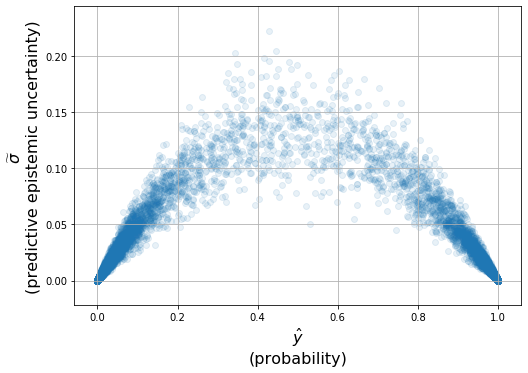

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5.5))
plt.scatter(preds_test, sigma_G_test, alpha=0.1)
plt.xlabel('$\hat{y}$\n(probability)', fontsize=16)
plt.ylabel('$\widetilde{\sigma}$\n(predictive epistemic uncertainty)', fontsize=16)
plt.grid()

# 4.2 Hessian estimator

## 4.2.1 Compute, store & initialize eigendecomposition

In [5]:
Lambda_H, Q_H, _ = dd.compute_eig_H()

np.save('data/Lambda_H_rseed_%d_layers_%s_K_%d_num_steps_%d_reg_lambda_%.2f.npy' 
        % (dd._rseed, 
           '-'.join(dd.layers), 
           dd.K, 
           num_steps, 
           dd.reg_lambda_val), Lambda_H)

np.save('data/Q_H_rseed_%d_layers_%s_K_%d_num_steps_%d_reg_lambda_%.2f.npy' 
        % (dd._rseed, 
           '-'.join(dd.layers), 
           dd.K, 
           num_steps, 
           dd.reg_lambda_val), Q_H)

dd.init_eig_H_op(Lambda_H, Q_H)

Starting Lanczos Iteration...


2330it [58:31,  1.51s/it]


Lanczos finished in 2330 iterations.


## 4.2.2 ...or just load & initialize pre-computed eigendecomposition

In [23]:
Lambda_H = np.load('data/Lambda_H_rseed_%d_layers_%s_K_%d_num_steps_%d_reg_lambda_%.2f.npy' 
                   % (dd._rseed, 
                      '-'.join(dd.layers), 
                      dd.K, 
                      num_steps, 
                      dd.reg_lambda_val))

Q_H = np.load('data/Q_H_rseed_%d_layers_%s_K_%d_num_steps_%d_reg_lambda_%.2f.npy' 
              % (dd._rseed, 
                 '-'.join(dd.layers), 
                 dd.K, 
                 num_steps, 
                 dd.reg_lambda_val))

dd.init_eig_H_op(Lambda_H, Q_H)

## 4.2.3 Compute predictive uncertainty for test set

In [24]:
sigma_H_test = np.sqrt(dd.eval_batched_var_H_op(X_test, progress=True))

100%|██████████| 100/100 [02:00<00:00,  1.17s/it]


## 4.2.4 Display predictive uncertainty as a function of probability

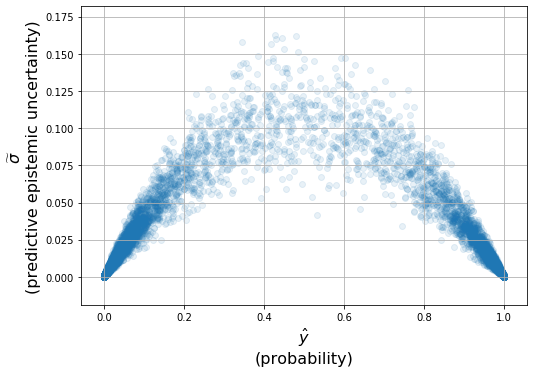

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5.5))
plt.scatter(preds_test, sigma_H_test, alpha=0.1)
plt.xlabel('$\hat{y}$\n(probability)', fontsize=16)
plt.ylabel('$\widetilde{\sigma}$\n(predictive epistemic uncertainty)', fontsize=16)
plt.grid()

# 4.3 Sandwich estimator

## 4.3.1 Compute predictive uncertainty for test set

In [28]:
sigma_S_test = np.sqrt(dd.eval_batched_var_Sandwich_op(X_test, progress=True))

100%|██████████| 100/100 [02:33<00:00,  1.47s/it]


## 4.3.2 Display predictive uncertainty as a function of probability

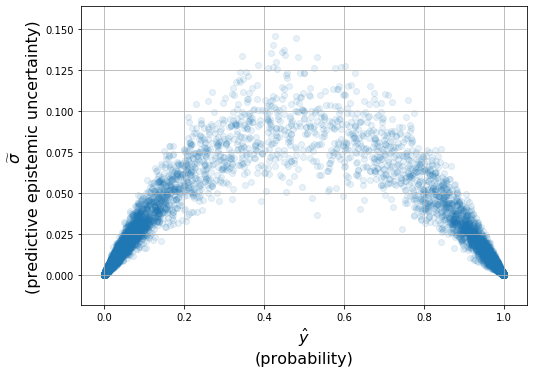

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5.5))
plt.scatter(preds_test, sigma_S_test, alpha=0.1)
plt.xlabel('$\hat{y}$\n(probability)', fontsize=16)
plt.ylabel('$\widetilde{\sigma}$\n(predictive epistemic uncertainty)', fontsize=16)
plt.grid()